# 鸢尾花分类


## 加载数据

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import pandas as pd

# 加载数据
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()
X = iris.data
y = iris.target

# 标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
# 根据 随机种子 将X 拆分成 占80%的 x_train 和 剩余20%的 X_test ， y_train 和 y_test 是 x_train 和 x_test 的 target 列 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转为张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [14]:
class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)  # 3类

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = IrisNet()

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_list = []
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.7439
Epoch 20, Loss: 0.5122
Epoch 30, Loss: 0.4010
Epoch 40, Loss: 0.3398
Epoch 50, Loss: 0.2896
Epoch 60, Loss: 0.2377
Epoch 70, Loss: 0.1893
Epoch 80, Loss: 0.1503
Epoch 90, Loss: 0.1211
Epoch 100, Loss: 0.0990


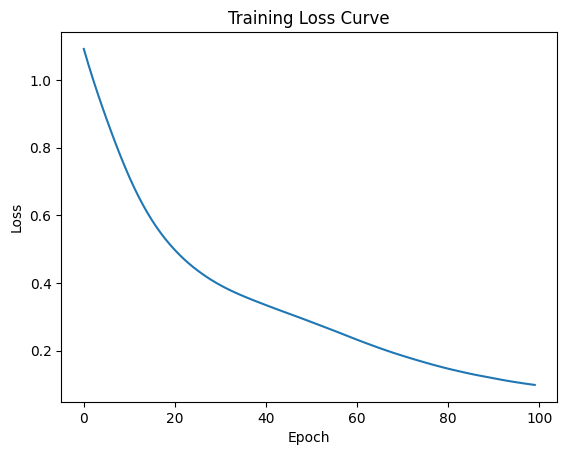

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [17]:
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 1.00


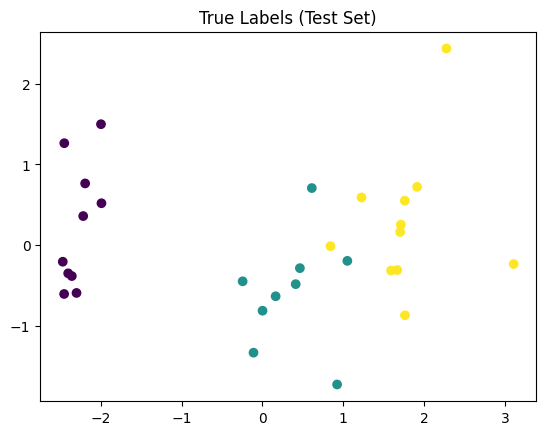

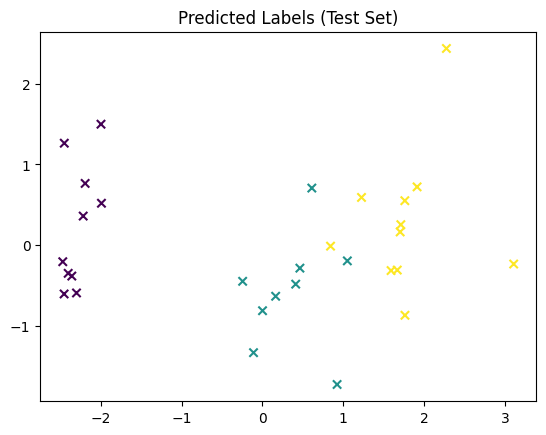

In [18]:
from sklearn.decomposition import PCA

# 降维
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test.numpy())

# 真实标签
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test.numpy(), cmap='viridis', marker='o', label='True')
plt.title('True Labels (Test Set)')
plt.show()

# 预测标签
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=predicted.numpy(), cmap='viridis', marker='x', label='Pred')
plt.title('Predicted Labels (Test Set)')
plt.show()

In [19]:
# 新样本，4个特征（需标准化处理）
new_sample = [[5.1, 3.5, 1.4, 0.2]]
new_sample = scaler.transform(new_sample)  # 用训练时的scaler标准化
new_sample = torch.tensor(new_sample, dtype=torch.float32)

# 用训练好的模型预测
with torch.no_grad():
    output = model(new_sample)
    predicted_class = torch.argmax(output, dim=1).item()
    print(f"预测类别: {predicted_class}")
    print(f"对应类别名称: {iris.target_names[predicted_class]}")

预测类别: 0
对应类别名称: setosa


In [20]:
# 保存模型
torch.save(model.state_dict(), 'iris_model.pth')

# 加载模型
model = IrisNet()
model.load_state_dict(torch.load('iris_model.pth'))
model.eval()  # 切换到评估模式

IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)